In [3]:
import os
import re

import numpy as np
from matplotlib import pyplot as plt
import keras
from keras.utils import pad_sequences, to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer

from models import LSTMModel

In [4]:
to_exclude = '!"#$%&()*+-/:;<=>@[\\]^_`{|}~\t'
to_tokenize = '.,:;!?\n'
tokenizer = Tokenizer(filters=to_exclude)

In [5]:
poem_dir = "data/poems/forms/ballad"
text = []
for file in sorted(os.listdir(poem_dir)):
    full_path = os.path.join(poem_dir, file)
    with open(full_path, encoding='utf-8-sig') as f:
        data = f.read()
    data = re.sub(r'(['+to_tokenize+'])', r' \1 ', data)
    text.append(data.lower() + ' \n')
text = text[:5]
print(text[0])

the burden of hard hitting .  slug away 
 like honus wagner or like tyrus cobb .  
 else fandom shouteth :  "who said you could play ?  
 back to the jasper league ,  you minor slob ! " 
 swat ,  hit ,  connect ,  line out ,  goet on the job .  
 else you shall feel the brunt of fandom's ire 
 biff ,  bang it ,  clout it ,  hit it on the knob - 
 this is the end of every fan's desire .  
 the burden of good pitching .  curved or straight .  
 or in or out ,  or haply up or down ,  
 to puzzle him that standeth by the plate ,  
 to lessen ,  so to speak ,  his bat-renown :  
 like christy mathewson or miner brown ,  
 so pitch that every man can but admire 
 and offer you the freedom of the town - 
 this is the end of every fan's desire .  
 the burden of loud cheering .  o the sounds !  
 the tumult and the shouting from the throats 
 of forty thousand at the polo grounds 
 sitting ,  ay ,  standing sans their hats and coats .  
 a mighty cheer that possibly denotes 
 that cub or pirat

In [6]:
tokenizer.fit_on_texts(text)
total_words = len(tokenizer.word_index) + 1
print(total_words)

791


In [7]:
input_sequences = []
max_sequence_len = 20

for line in text:
    token_list = tokenizer.texts_to_sequences([line])[0]
    seq = []
    for i in range(1, len(token_list)):
        start_index = max(0, i - max_sequence_len + 1)
        end_index = i + 1
        n_gram_sequence = token_list[start_index:end_index]
        seq.append(n_gram_sequence)
    input_sequences.extend(seq)

max_sequence_len = max([len(line) for line in input_sequences])
pad_input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

print(input_sequences[10])
print(text[0].split(' ')[:10])

[3, 23, 5, 252, 253, 6, 254, 255, 1, 33, 256, 257]
['the', 'burden', 'of', 'hard', 'hitting', '.', '', 'slug', 'away', '\n']


In [8]:
X, labels = pad_input_sequences[:, :-1], pad_input_sequences[:, -1]
y = to_categorical(labels, num_classes=total_words)

In [18]:
model = LSTMModel().create_with_attention(total_words=total_words, output_dim=512, max_sequence_len=max_sequence_len)
model.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 512)         404992    
                                                                 
 lstm_1 (LSTM)               (None, None, 256)         787456    
                                                                 
 attention (Attention)       (None, 791)               470528    
                                                                 
Total params: 1,662,976
Trainable params: 1,662,976
Non-trainable params: 0
_________________________________________________________________


In [19]:
class PredictionCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        seed = "All ours"
        next_words = 20

        for _ in range(next_words):
            token_list = tokenizer.texts_to_sequences([seed])[0]
            token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
            predicted = model.predict(token_list)[0]
            output_word = ""
            for word, index in tokenizer.word_index.items():
                if index == predicted:
                    output_word = word
                    break
            seed = " ".join([seed, output_word])
        print('\n', seed, '\n')

In [20]:
early_stopping = EarlyStopping(monitor="loss", patience=3)
model_checkpoint = ModelCheckpoint(
    filepath=model.MODEL_CHECKPOINT,
    save_weights_only=True,
    save_freq=5)

history = model.model.fit(
    X, y,
    epochs=20,
    batch_size=128,
    shuffle=True,
    callbacks=[model_checkpoint, PredictionCallback()]
)

Epoch 1/20
20/21 [===========================>..] - ETA: 0s - loss: 7.8837
 All ours trailing trailing trailing trailing trailing trailing trailing trailing trailing trailing trailing trailing trailing trailing trailing trailing barrels barrels barrels barrels 

21/21 [==============================] - 5s 141ms/step - loss: 7.8723
Epoch 2/20
19/21 [==========================>...] - ETA: 0s - loss: 6.7298
 All ours trailing trailing trailing trailing trailing trailing trailing trailing trailing trailing trailing trailing trailing trailing trailing trailing trailing trailing trailing trailing 

21/21 [==============================] - 2s 114ms/step - loss: 6.7285
Epoch 3/20
18/21 [========================>.....] - ETA: 0s - loss: 6.7074
 All ours bloodless bloodless bloodless wake bloodless bloodless wake bloodless bloodless wake bloodless bloodless wake bloodless wake bloodless bloodless wake wearier wearier 

21/21 [==============================] - 2s 115ms/step - loss: 6.7117
Epoch 4

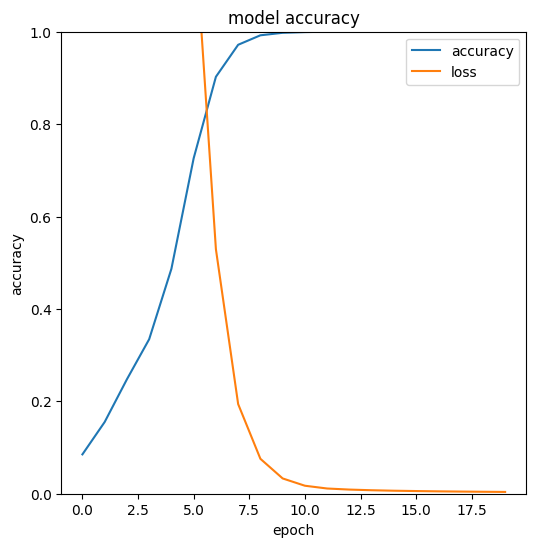

In [12]:
fig = plt.figure(figsize=(6, 6))
plt.plot(history.history['accuracy'], label="accuracy")
plt.plot(history.history['loss'], label="loss")
plt.ylim((0, 1))
plt.legend()
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()


In [13]:
model.save()

In [14]:
model = LSTMModel().load()

In [17]:
seed = "Oh"
next_words = 25

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list)[0]
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed = " ".join([seed, output_word])
print(seed)

Oh down here i chance to die , 
 solemnly i beg you take 
 all that is left of i 
 to the hills for
